In [1]:
from scipy.io import FortranFile as ff
import numpy as np
#np.set_printoptions(threshold=50)
import math
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm

In [2]:
#Define the directions 
directions = np.zeros((5,3))
directions[0,:] = [0.5, -0.866, 0.00]
directions[1,:] = [0.45, -0.78, 0.44]
directions[2,:] = [0.78, 0.45, 0.44]
directions[3,:] = [0.72, 0.181, -0.67]
directions[4,:] = [-0.48, -0.2, 0.85]

In [3]:
#Save v_cm for 107 : [-16.9071216  -42.91193192  43.09063188], in km/s
v_cm = [-16.9071216, -42.91193192, 43.09063188]

In [4]:
#Read the initial rays, to get the weights (computed based on the luminosity of the stars)
IC_file = '/cral/mauerhofer/RascasFiles/simu_jeremy/00107/SiII/CD/IC_CD_Si_1258_1262'
f = ff(IC_file,'r')
nrays = f.read_ints()[0]
f.read_reals()
weights = f.read_reals()
f.close()

In [5]:
print(nrays)
print(weights)

900185
[7.70385724e+44 7.20216520e+44 5.29629641e+44 ... 2.14624175e+45
 1.10723663e+45 3.41024294e+45]


In [6]:
#Read the output
output_CD_file = '/cral/mauerhofer/RascasFiles/simu_jeremy/00107/SiII/CD/output_CD_Si_1258_1262_1'
f = ff(output_CD_file,'r')
nrays = f.read_ints()[0]
ndirections = f.read_ints()[0]
nGas = f.read_ints()[0]
vmin, vmax = f.read_reals()
nBins = f.read_ints()[0]
dv = (vmax-vmin)/nBins
v = np.linspace(vmin - dv/2, vmax + dv/2, nBins+2)

In [7]:
print(ndirections, nGas, vmin, vmax, nBins)

5 2 -500.0 500.0 40


In [8]:
dust_file = '/cral/mauerhofer/RascasFiles/simu_jeremy/00107/SiII/CD/output_CD_Si_1258_1262_2'
f = ff(dust_file,'r')
CD_dust = np.zeros((ndirections,nrays))
f.read_ints()
f.read_ints()
f.read_ints()
f.read_reals()
f.read_ints()
for k in range(ndirections):
    CD = f.read_reals()
    CD2 = CD.reshape((nBins+2,nrays))
    CD_dust[k,:] = np.sum(CD2,axis=0)

/home/cral/mauerhofer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/cral/mauerhofer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less


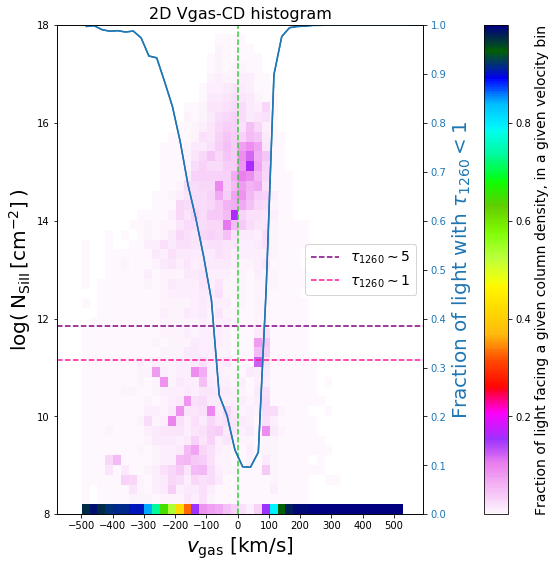

In [10]:
#SiII column density :
#Read the output
f.close()
output_CD_file = '/cral/mauerhofer/RascasFiles/simu_jeremy/00107/SiII/CD/output_CD_Si_1258_1262_1'
f = ff(output_CD_file,'r')
nrays = f.read_ints()[0]
ndirections = f.read_ints()[0]
nGas = f.read_ints()[0]
vmin, vmax = f.read_reals()
nBins = f.read_ints()[0]
dv = (vmax-vmin)/nBins
v = np.linspace(vmin - dv/2, vmax + dv/2, nBins+2)
for k in range(1):#ndirections):

    CD = f.read_reals()
    #CD begins with npart CD for the first bin of velocity,  then npart CD for the second bin,  etc
    CD2 = CD.reshape((nBins+2,nrays))

    #NEW
    CD[np.where(CD<1e8)] = 1e8
    
    CD[np.where(CD>0)] = np.log10(CD[np.where(CD>0)])

#     Question : 
#     for i in range(nrays):
#        weights[i] = weights[i]/np.where(CD2[:,i]!=0)[0].size
    
    #NEW
    v = v + np.dot(directions[k,:],v_cm)
    vmin = vmin + np.dot(directions[k,:],v_cm)
    vmax = vmax + np.dot(directions[k,:],v_cm)
    v_all = np.repeat(v,nrays)
    weights_dust = weights*np.exp(-6.93e-23*CD_dust[k,:])
    weights_all = np.tile(weights_dust,nBins+2)

    xedges = np.linspace(vmin-dv - np.dot(directions[k,:],v_cm), vmax + dv - np.dot(directions[k,:],v_cm),nBins+3)
    #NEW
    yedges = np.arange(8,18.1,0.2)

    histo, xedges, yedges = np.histogram2d(v_all, CD, bins=(xedges,yedges), weights=weights_all, normed=False)

    for i in range(histo[:,0].size):
        histo[i,:] = histo[i,:]/sum(histo[i,:])

    histo = np.ma.masked_where(histo < 0.0001, histo)
    cmap = plt.cm.gist_ncar_r
#     cmap = plt.cm.PuBu_r
#     cmap = plt.cm.revcmap
#     cmap = plt.cm.hsv_r
    cmap.set_bad(color='white')
    #cmap.set_bad(color='black')

    fig, ax = plt.subplots(figsize=(9,9))
    
    plt.imshow(histo.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap=cmap)#,norm=LogNorm())
    plt.axhline(11.85,color='purple',linestyle='--', label=r'$\tau_{1260} \sim 5$')
    plt.axhline(11.15,color='deeppink',linestyle='--', label=r'$\tau_{1260} \sim 1$')
    plt.axvline(0,color='limegreen',linestyle='--')
    plt.legend(loc='center right', fontsize=14)
    cbar = plt.colorbar(pad=0.12)
#     plt.clim(0,1)
    plt.xlabel(r'$v_{\rm{gas}}$ [km/s]', fontsize=20)
    plt.ylabel(r'$\rm{log}( \: N_{SiII} \, [\rm{cm}^{-2}] \: )$', fontsize=20)
    plt.title('2D Vgas-CD histogram', fontsize = 16)
    cbar.set_label('Fraction of light facing a given column density, in a given velocity bin', fontsize=14)
    plt.xticks(np.arange(xedges[0]+dv, xedges[-1]-dv+0.01, 100))
    
    fraction = np.zeros((nBins+2))
    for i in range(nBins+2):
        small_tau = np.where(CD2[i,:] < 11.15)
        small_L = weights_dust[small_tau]
        fraction[i] = sum(small_L)/sum(weights_dust)   
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel(r'Fraction of light with $\tau_{1260} < 1$', color=color, fontsize=20)
    ax2.set_ylim(0,1)
    ax2.plot(v, fraction, color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)
    plt.plot(v,fraction)
    
    plt.savefig('/home/cral/mauerhofer/figures/paper/CD/histo_tot.pdf')
    plt.show()
    plt.close()

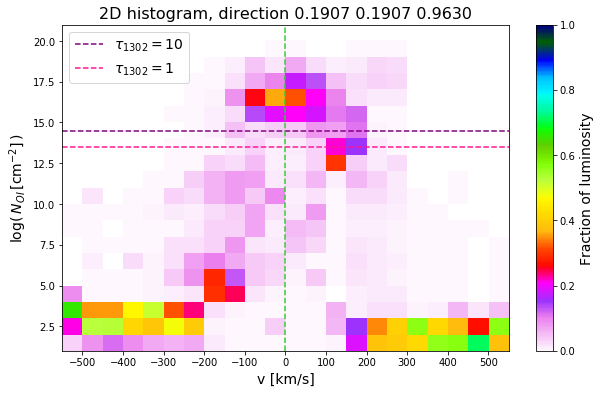

In [32]:
#OI column density :
#Read the output
f.close()
output_CD_file = '/cral/mauerhofer/RascasFiles/sphinx/05_F1000/02_IC20_BP/00183/Halo1/OI_SiII/CD/output_CD_1'
f = ff(output_CD_file,'r')
nrays = f.read_ints()[0]
ndirections = f.read_ints()[0]
nGas = f.read_ints()[0]
vmin, vmax = f.read_reals()
nBins = f.read_ints()[0]
dv = (vmax-vmin)/nBins
v = np.linspace(vmin - dv/2, vmax + dv/2, nBins+2)
for k in range(1):#ndirections):

    CD = f.read_reals()
    #CD begins with npart CD for the first bin of velocity,  then npart CD for the second bin,  etc

    CD[np.where(CD>0)] = np.log10(CD[np.where(CD>0)])

    #Question : 
    #for i in range(nrays):
    #    weights[i] = weights[i]/np.where(CD2[:,i]!=0)[0].size
    
    v_all = np.repeat(v,nrays)
    weights_dust = weights*np.exp(-6.5e-23*CD_dust[k,:])
    weights_all = np.tile(weights_dust,nBins+2)

    xedges = np.linspace(vmin-dv, vmax + dv,nBins+3)
    yedges = np.arange(1,21.1,1)

    histo, xedges, yedges = np.histogram2d(v_all, CD, bins=(xedges,yedges), weights=weights_all, normed=False)

    for i in range(histo[:,0].size):
        histo[i,:] = histo[i,:]/sum(histo[i,:])

    histo = np.ma.masked_where(histo < 0.0001, histo)
    cmap = plt.cm.gist_ncar_r
    #cmap = plt.cm.PuBu_r
    cmap.set_bad(color='white')
    #cmap.set_bad(color='black')

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(histo.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap=cmap)#,norm=LogNorm())
    plt.axhline(14.5,color='purple',linestyle='--', label=r'$\tau_{1302} = 10$')
    plt.axhline(13.5,color='deeppink',linestyle='--', label=r'$\tau_{1302} = 1$')
    plt.axvline(0,color='limegreen',linestyle='--')
    plt.legend(loc='upper left', fontsize=14)
    cbar = plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('v [km/s]', fontsize=14)
    plt.ylabel(r'$\mathrm{log}( \: N_{OI} \, [\mathrm{cm}^{-2}] \: )$', fontsize=14)
    #plt.title('2D histogram, direction %s'%directions[k], fontsize = 16)
    plt.title('2D histogram, direction %05.4f %05.4f %05.4f'%(directions[k,0],directions[k,1],directions[k,2]), fontsize = 16)
    cbar.set_label('Fraction of luminosity', fontsize=14)
    plt.xticks(np.arange(xedges[0]+dv, xedges[-1]-dv+0.01, 100))
    plt.show()
    #plt.savefig('/cral/mauerhofer/RascasFiles/sphinx/05_F1000/02_IC20_BP/00183/OI_SiII/CD/Halo1/histo_tot_O_%i.png'%k)
    plt.close()

In [23]:
f.close()

In [26]:
#SiII column density :
for k in range(ndirections):

    CD = f.read_reals()
    #CD begins with npart CD for the first bin of velocity,  then npart CD for the second bin,  etc

    CD[np.where(CD>0)] = np.log10(CD[np.where(CD>0)])

    #Question : 
    #for i in range(nrays):
    #    weights[i] = weights[i]/np.where(CD2[:,i]!=0)[0].size
    
    v_all = np.repeat(v,nrays)
    weights_all = np.tile(weights,nBins+2)

    xedges = np.linspace(vmin-dv, vmax + dv,nBins+3)
    yedges = np.arange(1,21.1,0.8)

    histo, xedges, yedges = np.histogram2d(v_all, CD, bins=(xedges,yedges), weights=weights_all, normed=False)

    for i in range(histo[:,0].size):
        histo[i,:] = histo[i,:]/sum(histo[i,:])

    histo = np.ma.masked_where(histo < 0.0001, histo)
    cmap = plt.cm.gist_ncar_r
    #cmap = plt.cm.PuBu_r
    cmap.set_bad(color='white')
    #cmap.set_bad(color='black')

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(histo.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap=cmap)#,norm=LogNorm())
    plt.axhline(13.03,color='purple',linestyle='--', label=r'$\tau_{1260} = 10$')
    plt.axhline(12.03,color='deeppink',linestyle='--', label=r'$\tau_{1260} = 1$')
    plt.axvline(0,color='limegreen',linestyle='--')
    plt.legend(loc='upper left', fontsize=14)
    cbar = plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('v [km/s]', fontsize=14)
    plt.ylabel(r'$\mathrm{log}( \: N_{SiII} \, [\mathrm{cm}^{-2}] \: )$', fontsize=14)
    #plt.title('2D histogram, direction %s'%directions[k], fontsize = 16)
    plt.title('2D histogram, direction %05.4f %05.4f %05.4f'%(directions[k,0],directions[k,1],directions[k,2]), fontsize = 16)
    cbar.set_label('Fraction of luminosity', fontsize=14)
    plt.xticks(np.arange(xedges[0]+dv, xedges[-1]-dv+0.01, 150))
    #plt.show()
    plt.savefig('/cral/mauerhofer/RascasFiles/sphinx/05_F1000/02_IC20_BP/00183/OI_SiII/CD/Halo1/histo_tot_Si_%i.png'%k)
    plt.close()

In [22]:
f.close()

In [11]:
#dust column density :
for k in range(ndirections):

    CD = f.read_reals()
    #CD begins with npart CD for the first bin of velocity,  then npart CD for the second bin,  etc

    CD[np.where(CD>0)] = np.log10(CD[np.where(CD>0)])

    #Question : 
    #for i in range(nrays):
    #    weights[i] = weights[i]/np.where(CD2[:,i]!=0)[0].size
    
    v_all = np.repeat(v,nrays)
    weights_all = np.tile(weights,nBins+2)

    xedges = np.linspace(vmin-dv, vmax + dv,nBins+3)
    yedges = np.arange(1,21.1,0.8)

    histo, xedges, yedges = np.histogram2d(v_all, CD, bins=(xedges,yedges), weights=weights_all, normed=False)

    for i in range(histo[:,0].size):
        histo[i,:] = histo[i,:]/sum(histo[i,:])

    histo = np.ma.masked_where(histo < 0.01, histo)
    cmap = plt.cm.gist_ncar_r
    #cmap = plt.cm.PuBu_r
    cmap.set_bad(color='white')
    #cmap.set_bad(color='black')

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(histo.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap=cmap)#,norm=LogNorm())
    plt.axhline(14.5,color='purple',linestyle='--', label=r'$\tau_{1302} = 10$')
    plt.axhline(13.5,color='deeppink',linestyle='--', label=r'$\tau_{1302} = 1$')
    plt.axvline(0,color='limegreen',linestyle='--')
    plt.legend(loc='upper left', fontsize=14)
    cbar = plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('v [km/s]', fontsize=14)
    plt.ylabel(r'$\mathrm{log}( \: N_{dust} \, [\mathrm{cm}^{-2}] \: )$', fontsize=14)
    #plt.title('2D histogram, direction %s'%directions[k], fontsize = 16)
    plt.title('2D histogram, direction %05.4f %05.4f %05.4f'%(directions[k,0],directions[k,1],directions[k,2]), fontsize = 16)
    cbar.set_label('Fraction of luminosity', fontsize=14)
    plt.xticks(np.arange(xedges[0]+dv, xedges[-1]-dv+0.01, 150))
    #plt.show()
    plt.savefig('/cral/mauerhofer/RascasFiles/sphinx/05_F1000/02_IC20_BP/00183/OI_SiII/CD/Halo1/histo_tot_dust_%i.png'%k)
    plt.close()

In [34]:
print(plt.style.available)

['Solarize_Light2', '_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'tableau-colorblind10']
